<img src="https://www.sparkcognition.com/wp-content/uploads/2019/11/SparkCognition-Logo-Color-e1573238635285.png">


<h1><center>DARWIN Forecasting SDK Example</center></h1>



<h3><center>Use Case - NYC Taxi Data</center></h3>

### Prior to getting started:

Darwin notebook will no longer support 'Register User' starting from 2.0. As a user, you must have credentials ready before using this notebook. 

In order to proceed, in the Environment Variables cell: 
1. Set your username and password to ensure that you're able to log in successfully
2. Set the path to the location of your datasets if you are using your own data.  The path is set for examples.
  <br><b>NOTE:</b> We provide two ways to analyze feature importance. One is to use the entire dataset; the other one is to analyze a few samples to understand individual samples. In the latter case, we advise users to use a small dataset (<=500) because it takes long time to process individual samples. 

Here are a few things to be mindful of:
1. For every run, check the job status (i.e. requested, failed, running, completed) and wait for job to complete before proceeding. 
2. If you're not satisfied with your model and think that Darwin can benefit from extra training, use the resume function.

### Forecasting with DARWIN

- DARWIN uses a state-of-art performance model employing **seq-2-seq based architecture with dual stage attention mechanism**. 
- It can handle both univariate as well as multivariate time series. 
- Also in case of multivariate time series, unlike ARIMAX/SARIMAX or other conventional auto-regressive model, you don't need the exogenous variable while making future forecasts

Some of the important things to note while using DARWIN forecasting-sdk are - 

1). Choosing an appropriate **forecast_horizon** (depends on the data and the user's requirement)

2). Model **max_train_time** should be selected keeping in mind the **forecast_horizon** specified. Higher the **forecast_horizon**, proportionally higher time is required to train the model

### Import Necessary Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
from IPython.display import Image
from time import sleep
from amb_sdk.sdk import DarwinSdk
from sklearn.metrics import r2_score, mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Set Darwin SDK

In [2]:
from amb_sdk.sdk import DarwinSdk
ds = DarwinSdk()
ds.set_url('https://darwin-api.sparkcognition.com/v1/')

(True, 'http://localhost:5000/v1/')

### Environment Variables

In [3]:
PATH_TO_DATASET = '../../sets/'
TRAIN_DATASET = 'nyc_taxi_train.csv'
TEST_DATASET = 'nyc_taxi_test.csv'

ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

In [4]:
#Set your user id and password accordingly
USER="[your Darwin user id]"
PW="[your Darwin password]"

status, msg = ds.auth_login_user(USER, PW)
if not status:
    print(msg)
else:
    print('You are logged in.')

### Data Upload

**Read dataset and view a file snippet**

In [6]:
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
df.head()

,timestamp,value,hour,month,dayofweek,day
0,2014-07-01 00:00:00,10844,0,7,1,1
1,2014-07-01 00:30:00,8127,0,7,1,1
2,2014-07-01 01:00:00,6210,1,7,1,1
3,2014-07-01 01:30:00,4656,1,7,1,1
4,2014-07-01 02:00:00,3820,2,7,1,1


**Upload training dataset to Darwin**

In [7]:
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TRAIN_DATASET))
if not status:
    print(dataset)
else:
    print('Data is successfully uploaded!')

400: BAD REQUEST - {"message": "Dataset already exists"}



#### **Upload testing dataset to Darwin**

In [8]:
status, dataset = ds.upload_dataset(os.path.join(PATH_TO_DATASET, TEST_DATASET))
if not status:
    print(dataset)
else:
    print('Data is successfully uploaded!')

400: BAD REQUEST - {"message": "Dataset already exists"}



### Analyze Data
Analyze data is a necessary step before cleaning data and creating model. 

In [9]:
status, analyze_id = ds.analyze_data(TRAIN_DATASET, 
                                     job_name = 'Darwin_analyze_data_job' + "-" + ts, 
                                     artifact_name = 'Darwin_analyze_data_artifact' + "-" + ts)
sleep(1)
if status:
    ds.wait_for_job('Darwin_analyze_data_job' + "-" + ts)
else:
    print(analyze_id)

400: BAD REQUEST - {"message": "A raw profile (name:Darwin_analyze_data_artifact-20200114135450) already exists for this dataset"}



### Clean Data
Every dataset needs to be cleaned before creating a model. There is no need to save the cleaned data and upload it, but users need to specify the target name before running.

In [11]:
target = 'value'
status, job_id_clean = ds.clean_data(dataset_name=TRAIN_DATASET, target=target)
if not status:
    print(job_id_clean)
else:
    print('Data is being cleaned.')
    ds.wait_for_job(job_id_clean['job_name'])

Data is being cleaned.
{'status': 'Running', 'starttime': '2020-01-14T23:42:50.152767', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['nyc_taxi_train.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2020-01-14T23:42:50.152767', 'endtime': '2020-01-14T23:42:53.30244', 'percent_complete': 100, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['nyc_taxi_train.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}


In [12]:
job_id_clean

{'job_name': 'bd0d236aadee4a0eacf0116c9af7cddc',
 'job_id': '933a2b6d-3727-11ea-88dc-93c8e1b8ec3f',
 'profile_name': '2f111c8c78a14b858dc8a343e53fa840',
 'profile_id': '933a2b6e-3727-11ea-88dc-039ae5588ca6'}

**for downloading the cleaned dataset/artifact**<br>
Prior to running the cell below, fastparquet and python-snappy needs to be installed.

In [13]:
# status, download = ds.download_dataset(job_id_clean['profile_name'])
# dat = pd.read_parquet(download['filename'], engine='fastparquet', )
# dat.head(2)

### Create and Train Model 

In the cell below, specify the parameters used to create the forecasting model:
- `model`: the name of your model
- `forecast_horizon`: the forecast length, which is how far you need to predict in the future, int type
- `max_train_time`: the amount of time used for training (possibly shorter with early stopping)

**NOTE : max_train_time should be carefully selected depending upon the given forecast_horizon. Longer forecast_horizon needs proportionally longer training time**

In [14]:
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
model = "model" + "-" + ts
forecast_horizon = 3
max_train_time = '00:05'
status, job_id_create = ds.create_model(dataset_names=TRAIN_DATASET,
                                 model_name=model,
                                 forecast_horizon=forecast_horizon,
                                 fit_profile_name=job_id_clean['profile_name'],
                                 max_train_time=max_train_time)
sleep(1)
if status:
    ds.wait_for_job(job_id_create['job_name'], 1200)
else:
    print(job_id_create)

{'status': 'Running', 'starttime': '2020-01-14T23:43:06.954095', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['nyc_taxi_train.csv'], 'artifact_names': None, 'model_name': 'model-20200114174305', 'job_error': ''}
{'status': 'Running', 'starttime': '2020-01-14T23:43:06.954095', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['nyc_taxi_train.csv'], 'artifact_names': None, 'model_name': 'model-20200114174305', 'job_error': ''}
{'status': 'Running', 'starttime': '2020-01-14T23:43:06.954095', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['nyc_taxi_train.csv'], 'artifact_names': None, 'model_name': 'model-20200114174305', 'job_error': ''}
{'status': 'Running', 'starttime': '2020-01-14T23:43:06.954095', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'gener

**In case of stopping the running job**

uncomment the following & run

In [15]:
#ds.stop_job(job_id_create['job_name'])

In [16]:
# look up job status
ds.lookup_job_status_name(job_id_create['job_name'])

(True,
 {'status': 'Complete',
  'starttime': '2020-01-14T23:43:06.954095',
  'endtime': '2020-01-14T23:48:31.857225',
  'percent_complete': 100,
  'job_type': 'TrainModel',
  'loss': 0.05884156539104879,
  'generations': 1,
  'dataset_names': ['nyc_taxi_train.csv'],
  'artifact_names': None,
  'model_name': 'model-20200114174305',
  'job_error': ''})

In [17]:
# look up the model details
model_info = ds.lookup_model_name(job_id_create['model_name'])
model_info

(True,
 {'id': '9d3d8afa-3727-11ea-88dc-97b97679b044',
  'name': 'model-20200114174305',
  'type': 'Supervised',
  'problem_type': None,
  'updated_at': '2020-01-14T23:48:31.852732',
  'trained_on': ['nyc_taxi_train.csv'],
  'trained_on_id': ['bb014e34-3707-11ea-88dc-d34b072ffcdd'],
  'loss': 0.05884156539104879,
  'complete': True,
  'generations': 1,
  'parameters': {'forecast_horizon': 3,
   'train_time': '00:05',
   'target': 'value',
   'recurrent': False,
   'max_unique_values': 50,
   'max_int_uniques': 15,
   'impute': 'mean',
   'big_data': False},
  'description': {'best_genome': [{'layer 1': {'type': 'DualAttentionRecurrentNeuralNet',
      'parameters': {'encoder_hidden_size': 50,
       'decoder_hidden_size': 72,
       'seqlength': 16}}},
    {'layer 2': {'type': 'LinearGene',
      'parameters': {'activation': 'identity', 'numunits': 3}}}],
   'recurrent': True,
   'genome_type': 'DeepNet'},
  'train_time_seconds': 325,
  'algorithm': None,
  'running_job_id': None})

In [18]:
job_id_create

{'job_name': 'c2e896a7f7ff4dfcbfd1423ccc4d2371',
 'job_id': '9d3d8afc-3727-11ea-88dc-4f2597d7b801',
 'model_name': 'model-20200114174305'}

#### Extra Training (Optional)

In [19]:
# max_train_time = '00:30'
# status, job_id_resume = ds.resume_training_model(dataset_names=TRAIN_DATASET,
#                                           model_name=model,
#                                           max_train_time=max_train_time)
# sleep(1)
# if status:
#     ds.wait_for_job(job_id_resume['job_name'], 2000)
# else:
#     print(job_id_resume)

### Predict

Analyze data is a necessary step before cleaning the test dataset and making predictions.

In [29]:
status, analyze_id = ds.analyze_data(TEST_DATASET, 
                                     job_name = 'Darwin_analyze_test_data_job' + "-" + ts, 
                                     artifact_name = 'Darwin_analyze_test_data_artifact' + "-" + ts)
sleep(1)
if status:
    ds.wait_for_job('Darwin_analyze_test_data_job' + "-" + ts)
else:
    print(analyze_id)

{'status': 'Complete', 'starttime': '2020-01-29T15:34:34.593642', 'endtime': '2020-01-29T15:34:37.138601', 'percent_complete': 100, 'job_type': 'AnalyzeData', 'loss': None, 'generations': None, 'dataset_names': ['nyc_taxi_test.csv'], 'artifact_names': ['Darwin_analyze_test_data_artifact-20200129085912'], 'model_name': None, 'job_error': None}


In [30]:
# clean dataset
status, job_id_clean = ds.clean_data(TEST_DATASET, model_name=model)

if status:
    ds.wait_for_job(job_id_clean['job_name'])
else:
    print(job_id_clean)

{'status': 'Running', 'starttime': '2020-01-29T15:41:37.361418', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['nyc_taxi_test.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2020-01-29T15:41:37.361418', 'endtime': '2020-01-29T15:41:42.34915', 'percent_complete': 100, 'job_type': 'CleanData', 'loss': None, 'generations': None, 'dataset_names': ['nyc_taxi_test.csv'], 'artifact_names': None, 'model_name': None, 'job_error': None}


In [21]:
job_id_clean

{'job_name': 'dd4b8368b54e4b9397eecc5331349238',
 'job_id': '62d7f701-3728-11ea-88dc-83297919887c',
 'profile_name': '4de3d18c8908405e94dea2ab53775abd',
 'profile_id': '62d7f702-3728-11ea-88dc-8be2d1a76a5f'}

In [22]:
# Test model
status, artifact = ds.run_model(dataset_name=TEST_DATASET, 
                                model_name=model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)

{'status': 'Running', 'starttime': '2020-01-14T23:48:56.335914', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.05884156539104879, 'generations': 1, 'dataset_names': ['nyc_taxi_test.csv'], 'artifact_names': ['b7fb01d843344d35994d974822b8c82e'], 'model_name': 'model-20200114174305', 'job_error': ''}
{'status': 'Complete', 'starttime': '2020-01-14T23:48:56.335914', 'endtime': '2020-01-14T23:49:10.042011', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.05884156539104879, 'generations': 1, 'dataset_names': ['nyc_taxi_test.csv'], 'artifact_names': ['b7fb01d843344d35994d974822b8c82e'], 'model_name': 'model-20200114174305', 'job_error': ''}


In [23]:
artifact

{'job_name': '2fcea1fcd24842e6949d2e19a056ab56',
 'job_id': '6d7d4f03-3728-11ea-88dc-c79f74bb346b',
 'artifact_name': 'b7fb01d843344d35994d974822b8c82e'}

In [24]:
# Get predictions
status, prediction = ds.download_artifact(artifact['artifact_name'])

In [25]:
# read in test dataset
df = pd.read_csv(os.path.join(PATH_TO_DATASET, TEST_DATASET))
# If TS has a datetime column
try :
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    print(df.head())
except:
    print(df.head())

                     value  hour  month  dayofweek  day
timestamp                                              
2015-01-11 13:00:00  21296    13      1          6   11
2015-01-11 13:30:00  20381    13      1          6   11
2015-01-11 14:00:00  19508    14      1          6   11
2015-01-11 14:30:00  19210    14      1          6   11
2015-01-11 15:00:00  18255    15      1          6   11


**aligning & re-structuring forecasting predictions**

In [26]:
trues, preds = ds.align_forecasting_predictions(model_name=model, true_values=df, predictions=prediction)

### Visualization the forecasting results

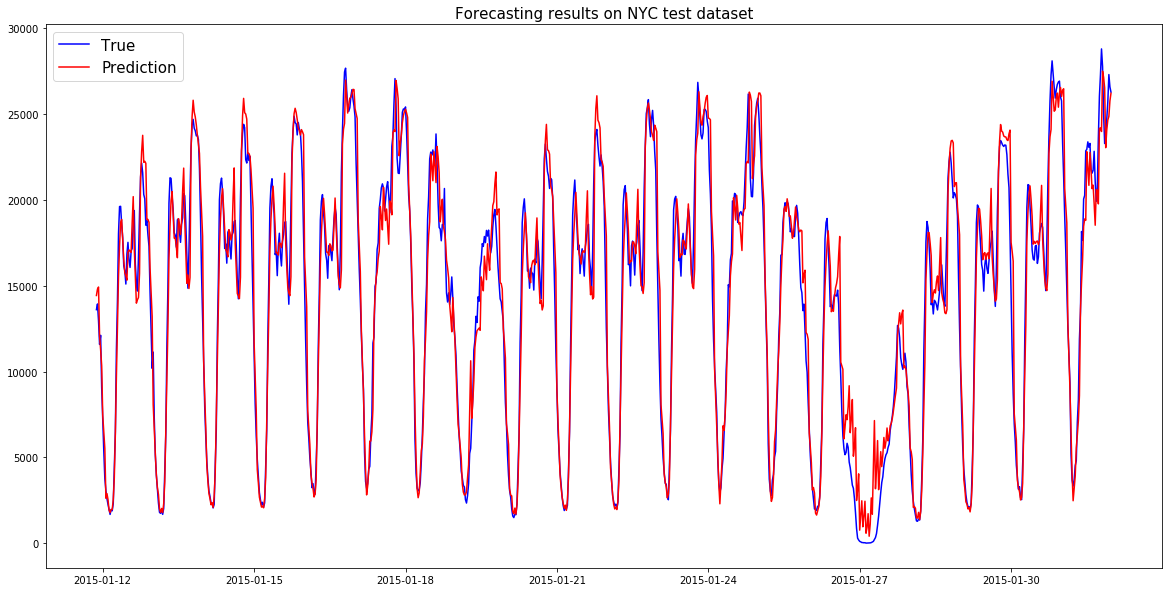

In [31]:
# plot against predictions

seq_len = model_info[1]['description']['best_genome'][0]['layer 1']['parameters']['seqlength']

plt.rcParams['figure.figsize']= 20,10
plt.plot(trues[target], color='b', label='True')
plt.plot(preds, color='r', label='Prediction')
plt.title("Forecasting results on NYC test dataset", fontsize=15)
plt.legend(fontsize=15)

#### Test Metrics 

In [33]:
r2_score(trues[target], preds)

0.9439938157948213

In [34]:
mean_squared_error(trues[target], preds)

3146232.7358638663